# Perform a thorough analysis and prediction of Microsoft stock

### Aim to find out:
1. The most impacting factors in each of the three datasets collected
2. Compare the performance of:
    * basic XGBoost models
    * advanced LSTMs
    * classical methods with facebook PROPHET2
3. The feasibility of prediction based on news sentiments alone
4. Find the most impactful news outlet - closest one to real prediction of the stock

### The final goal would be to create an automatic version that would go over all stocks and suggest the most profitable one

# Step1: Create the dataset to train on

## Pull all the data from alpha vantage

In [81]:
import requests
from pprint import pprint
import mplfinance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
import json
import time
from tqdm import tqdm
import calendar
import os
import logging
colors = sns.color_palette()
sns.set()
pd.set_option('display.max_colwidth',1000)
os.makedirs('msft_data', exist_ok=True)
os.makedirs('datasets', exist_ok=True)

In [82]:
# set up logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
# create a file handler
handler = logging.FileHandler('msft_analysis.log')
handler.setLevel(logging.INFO)
# create a logging format
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(handler)

In [85]:
import string
import random

def get_data(parameters):
    endpoint = "https://www.alphavantage.co/query"
    for _ in range(100):
        parameters['apikey'] = ''.join(random.choices(string.ascii_uppercase + string.digits, k=15))
        # Send a GET request to the API endpoint
        response = requests.get(endpoint, params=parameters)
        # Check if the request was successful
        if response.status_code == 200:
            data = response.json()
            if 'Note' not in data: 
                break
            logger.warning(f'API key {parameters["apikey"]} has been used too many times. response note: {data["Note"]}')
            data = None
            time.sleep(1)
        else: 
            logger.error(f'API key {parameters["apikey"]} has returned an error. response note: {response.json()}')
    return data

### Get all prices up to 2 years ago

In [165]:
parameters = {
        "function": "TIME_SERIES_DAILY_ADJUSTED",
        "symbol": 'MSFT',
        "outputsize": 'full'
    }
prices = get_data(parameters)
# convert to pandas dataframe
price_df = pd.DataFrame.from_dict(prices['Time Series (Daily)'], orient='index')
price_df.index = pd.to_datetime(price_df.index)
# rename columns
price_df.columns = ['open', 'high', 'low', 'close', 'adjusted_close', 'volume', 'dividend_amount', 'split_coefficient']

Add data regarding the low high and moving averages

In [166]:
price_df.sort_index(inplace=True)
# take a moving average of the adjusted close price
price_df['30_day_MA'] = price_df['adjusted_close'].rolling(30).mean()
price_df['50_day_MA'] = price_df['adjusted_close'].rolling(30).mean()
price_df['100_day_MA'] = price_df['adjusted_close'].rolling(100).mean()
price_df['200_day_MA'] = price_df['adjusted_close'].rolling(200).mean()
# the highs and lows
price_df['4_week_high'] = price_df['adjusted_close'].rolling(4*7).max()
price_df['4_week_low'] = price_df['adjusted_close'].rolling(4*7).min()
price_df['10_week_high'] = price_df['adjusted_close'].rolling(10*7).max()
price_df['10_week_low'] = price_df['adjusted_close'].rolling(10*7).min()
price_df['52_week_high'] = price_df['adjusted_close'].rolling(52*7).max()
price_df['52_week_low'] = price_df['adjusted_close'].rolling(52*7).min()
# take only the data up to 2 years ago and convert to numeric
price_df = price_df[price_df.index > datetime.now() - timedelta(days=365*2)].apply(pd.to_numeric).dropna().sort_index(ascending=False)
price_df

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,30_day_MA,50_day_MA,100_day_MA,200_day_MA,4_week_high,4_week_low,10_week_high,10_week_low,52_week_high,52_week_low
2023-02-08,273.2000,276.760,266.21,266.73,266.730000,54686049,0.00,1.0,242.156667,242.156667,240.378834,253.116658,267.560000,222.310000,267.560000,213.648993,339.886190,213.648993
2023-02-07,260.5300,268.775,260.08,267.56,267.560000,50841365,0.00,1.0,241.223333,241.223333,240.158451,253.143094,267.560000,222.310000,267.560000,213.648993,339.886190,213.648993
2023-02-06,257.4400,258.300,254.78,256.77,256.770000,22517997,0.00,1.0,240.244333,240.244333,239.997976,253.199031,264.600000,222.310000,264.600000,213.648993,339.886190,213.648993
2023-02-03,259.5420,264.200,257.10,258.35,258.350000,29077256,0.00,1.0,239.833000,239.833000,239.943107,253.336464,264.600000,222.310000,264.600000,213.648993,339.886190,213.648993
2023-02-02,258.8200,264.690,257.25,264.60,264.600000,39940437,0.00,1.0,239.281333,239.281333,240.018627,253.460736,264.600000,222.310000,264.600000,213.648993,339.886190,213.648993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-17,241.3200,244.310,240.94,244.20,240.446023,21451617,0.56,1.0,226.378745,226.378745,215.223840,205.951357,240.671969,208.901972,240.671969,206.406740,240.671969,130.445065
2021-02-16,245.0300,246.130,242.92,243.70,239.404705,26728487,0.00,1.0,225.492315,225.492315,214.784711,205.599912,240.671969,208.509022,240.671969,206.406740,240.671969,130.445065
2021-02-12,243.9332,245.300,242.73,244.99,240.671969,16561079,0.00,1.0,224.795484,224.795484,214.422914,205.276287,240.671969,208.509022,240.671969,202.255015,240.671969,130.445065
2021-02-11,244.7800,245.150,242.15,244.49,240.180781,15751059,0.00,1.0,224.032179,224.032179,214.000631,204.937651,240.180781,208.509022,240.180781,198.237936,240.180781,130.445065


Save the daily dataframe and plot it

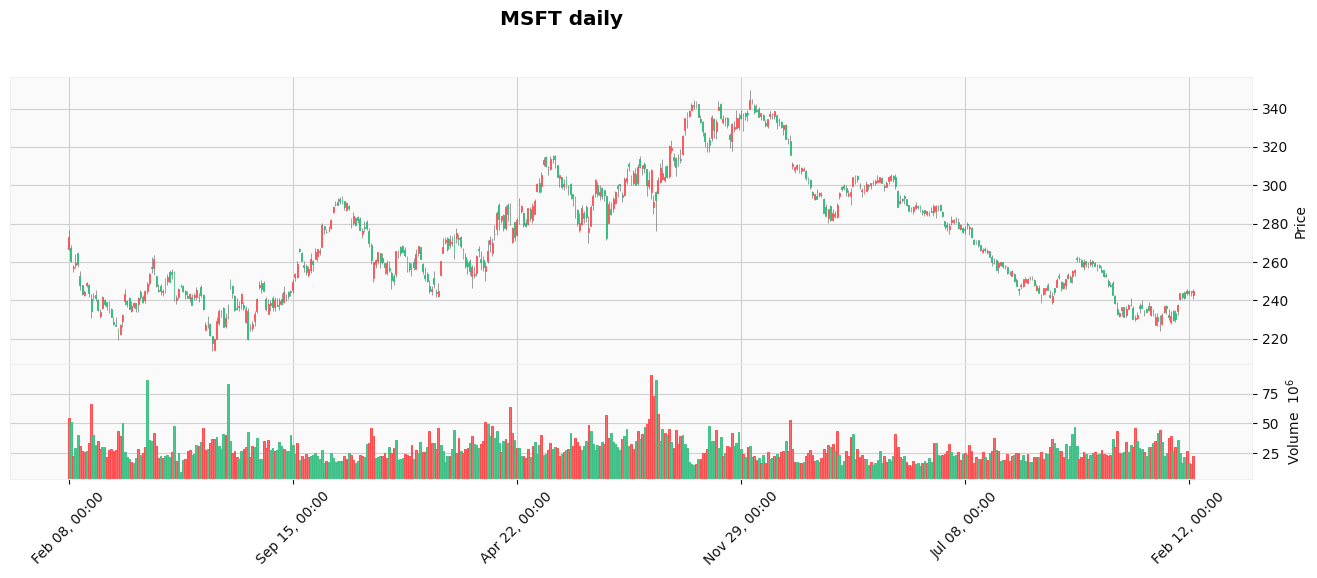

In [326]:
# save to csv
price_df.to_csv('datasets/msft_daily_prices.csv', index=True)
# create a candlestick plot
mplfinance.plot(price_df[['open', 'high', 'low', 'close', 'volume']], type='candle', style='yahoo', volume=True, title='MSFT daily', figratio=(15, 5))

Save the weekly dataframe and plot it

In [328]:
# subsample dataframe to get weekly data
weekly_df = price_df.resample('W').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'adjusted_close': 'last', 'volume': 'sum', '30_day_MA': 'last', '50_day_MA': 'last', '100_day_MA': 'last', '200_day_MA': 'last', '4_week_high': 'last', '4_week_low': 'last', '10_week_high': 'last', '10_week_low': 'last', '52_week_high': 'last', '52_week_low': 'last'})
# drop any timestamp that is later than today
weekly_df = weekly_df[weekly_df.index <= datetime.now()].sort_index(ascending=False)
weekly_df.head()

,open,high,low,close,adjusted_close,volume,30_day_MA,50_day_MA,100_day_MA,200_day_MA,4_week_high,4_week_low,10_week_high,10_week_low,52_week_high,52_week_low
2023-02-05,244.51,264.69,242.20,258.35,258.35,152686042,239.833000,239.833000,239.943107,253.336464,264.60,222.31,264.60,213.648993,339.88619,213.648993
2023-01-29,241.10,249.83,230.90,248.16,248.16,198648466,238.731333,238.731333,240.254113,254.030035,248.16,222.31,257.22,213.648993,339.88619,213.648993
2023-01-22,237.97,242.38,230.68,240.22,240.22,123872791,239.572333,239.572333,241.064874,255.338117,257.22,222.31,257.22,213.648993,339.88619,213.648993
2023-01-15,226.45,239.90,226.41,239.23,239.23,131675747,241.463000,241.463000,242.542640,256.783586,257.22,222.31,257.22,213.648993,339.88619,213.648993
2023-01-08,243.08,245.75,219.35,224.93,224.93,159562627,243.557000,243.557000,245.182300,258.546771,257.22,222.31,257.22,213.648993,339.88619,213.648993


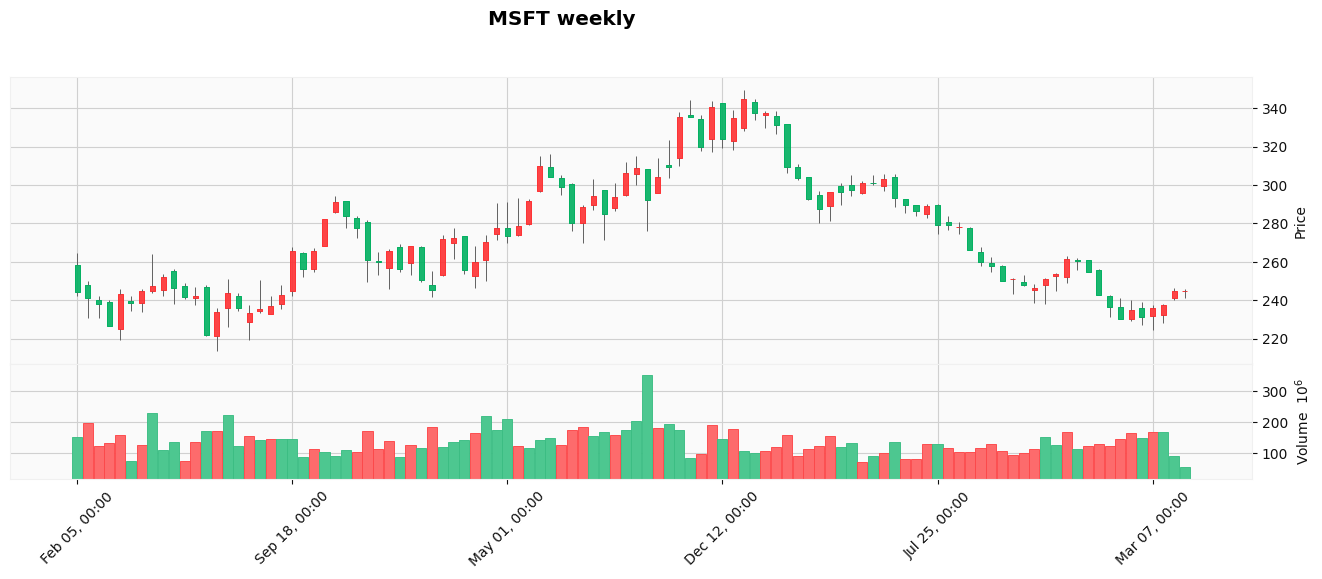

In [329]:
# save to csv
weekly_df.to_csv('datasets/msft_weekly_prices.csv', index=True)
# create a candlestick plot
mplfinance.plot(weekly_df[['open', 'high', 'low', 'close', 'volume']], type='candle', style='yahoo', volume=True, title='MSFT weekly', figratio=(15, 5))

Save the monthly dataframe and plot it

In [330]:
# subsample dataframe to get weekly data
monthly_df = price_df.resample('M').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'adjusted_close': 'last', 'volume': 'sum', '30_day_MA': 'last', '50_day_MA': 'last', '100_day_MA': 'last', '200_day_MA': 'last', '4_week_high': 'last', '4_week_low': 'last', '10_week_high': 'last', '10_week_low': 'last', '52_week_high': 'last', '52_week_low': 'last'})
# drop any timestamp that is later than today
monthly_df = monthly_df[monthly_df.index <= datetime.now()].sort_index(ascending=False)
monthly_df.head()

,open,high,low,close,adjusted_close,volume,30_day_MA,50_day_MA,100_day_MA,200_day_MA,4_week_high,4_week_low,10_week_high,10_week_low,52_week_high,52_week_low
2023-01-31,243.08,249.830,219.350,247.81,247.810000,666168068,238.207667,238.207667,240.060257,253.655157,248.160000,222.310000,257.220000,213.648993,339.88619,213.648993
2022-12-31,253.87,263.915,233.870,239.82,239.820000,591366468,245.359000,245.359000,247.581517,259.917491,257.220000,234.530000,257.220000,213.648993,339.88619,213.648993
2022-11-30,234.60,255.330,213.431,255.14,255.140000,615328220,236.946295,236.946295,251.915371,264.324129,255.140000,213.648993,278.067780,213.648993,339.88619,213.648993
2022-10-31,235.41,251.040,219.130,232.13,231.478837,671366804,236.782252,236.782252,255.992557,270.912427,249.956857,224.777688,292.025267,224.777688,339.88619,224.777688
2022-09-30,258.87,267.450,232.730,232.90,232.246677,575416752,254.439248,254.439248,261.613274,280.071412,278.067780,232.246677,292.025267,232.246677,339.88619,232.246677


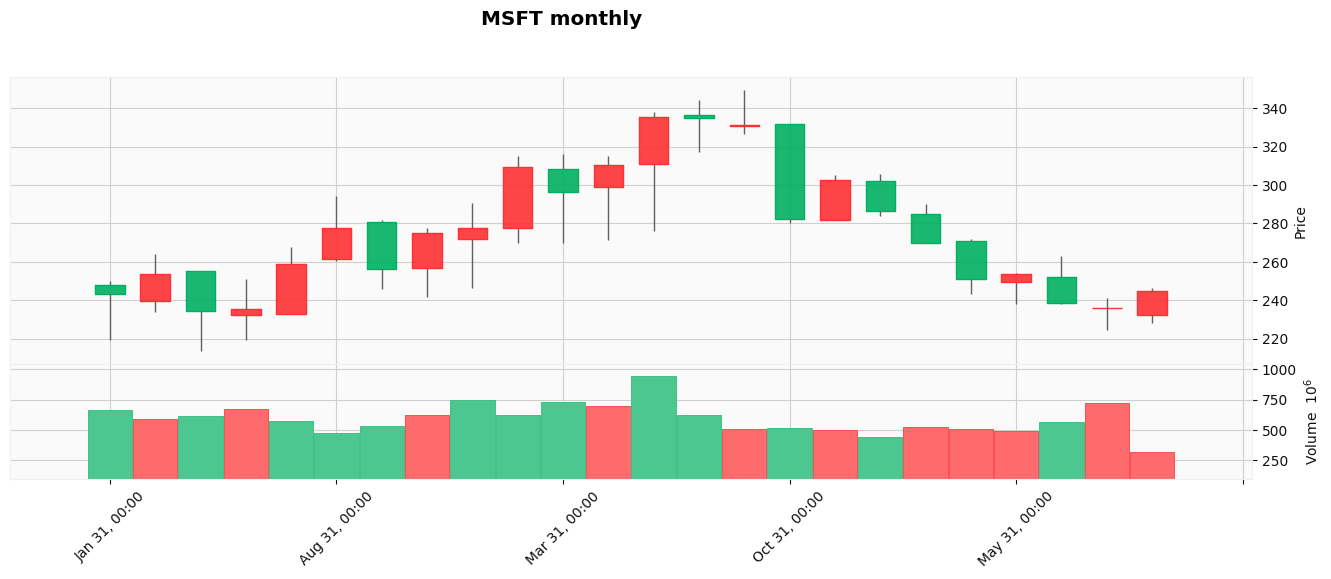

In [331]:
# save to csv
monthly_df.to_csv('datasets/msft_monthly_prices.csv', index=True)
# create a candlestick plot
mplfinance.plot(monthly_df[['open', 'high', 'low', 'close', 'volume']], type='candle', style='yahoo', volume=True, title='MSFT monthly', figratio=(15, 5))

### get all the company's financial sheets

Pull all financial sheets from alpha vantage

In [152]:
functions = ['OVERVIEW', 'INCOME_STATEMENT', 'BALANCE_SHEET', 'CASH_FLOW', 'EARNINGS']
overviews = [get_data({"function": function, "symbol": 'MSFT', "horizon": "12month"}) for function in functions]
# save to json in a different directory
for overview, function in zip(overviews, functions):
    with open(f'msft_data/msft_{function.lower()}.json', 'w') as outfile:
        json.dump(overview, outfile, indent=4)

Create the overview dataframe

In [153]:
def convert_overview_to_dataframe(overview):
    keys = []
    cols = []
    for key, val in overview.items():
        try:
            cols.append(float(val))
            if key not in keys: keys.append(key)
        # create an exception when the value is not a number
        except ValueError:
            try:
                cols.append(datetime.strptime(val, '%Y-%m-%d'))
                if key not in keys: keys.append(key)
            except ValueError:
                pass
    # return keys, cols
    return pd.DataFrame([cols], columns=keys)

overview_df = convert_overview_to_dataframe(overviews[0])
overview_df.to_csv('datasets/msft_overview.csv', index=False)
overview_df

,CIK,LatestQuarter,MarketCapitalization,EBITDA,PERatio,PEGRatio,BookValue,DividendPerShare,DividendYield,EPS,...,EVToRevenue,EVToEBITDA,Beta,52WeekHigh,52WeekLow,50DayMovingAverage,200DayMovingAverage,SharesOutstanding,DividendDate,ExDividendDate
0,789019.0,2022-12-31,1.991664e+12,9.794500e+10,27.7,2.275,24.59,2.6,0.0106,8.99,...,9.21,18.55,0.916,313.66,212.83,243.78,253.95,7.443800e+09,2023-03-09,2023-02-15


Create the earnings dataframe

In [154]:
earnings_ds = pd.DataFrame.from_dict(overviews[4]['quarterlyEarnings'])
earnings_ds['fiscalDateEnding'] = pd.to_datetime(earnings_ds['fiscalDateEnding'])
earnings_ds['reportedDate'] = pd.to_datetime(earnings_ds['reportedDate'])
# take only up to 2 years ago
earnings_ds = earnings_ds[earnings_ds['fiscalDateEnding'] > datetime.now() - timedelta(days=365*2)]
# convert all columns to numeric except the first two
earnings_ds.iloc[:, 2:] = earnings_ds.iloc[:, 2:].apply(pd.to_numeric)
# save to csv
earnings_ds.to_csv('datasets/msft_earnings.csv', index=False)
earnings_ds

,fiscalDateEnding,reportedDate,reportedEPS,estimatedEPS,surprise,surprisePercentage
0,2022-12-31,2023-01-24,2.32,2.30,0.02,0.8696
1,2022-09-30,2022-10-25,2.35,2.30,0.05,2.1739
2,2022-06-30,2022-07-26,2.23,2.29,-0.06,-2.6201
3,2022-03-31,2022-04-26,2.22,2.19,0.03,1.3699
4,2021-12-31,2022-01-25,2.48,2.31,0.17,7.3593
5,2021-09-30,2021-10-26,2.27,2.08,0.19,9.1346
6,2021-06-30,2021-07-27,2.17,1.92,0.25,13.0208
7,2021-03-31,2021-04-27,2.03,1.78,0.25,14.0449


### Get all the news sentiments

Reload the previous dataset

In [171]:
try: 
    sent_df = pd.read_csv('datasets/msft_sentiments.csv').drop(columns=['Unnamed: 0'], errors='ignore')
except FileNotFoundError: 
    sent_df = pd.DataFrame()

Create a new dataframe from the saved jsons

In [172]:
rows = []
# get a list of all files in the sentiments folder
for news_file in tqdm(os.listdir('sentiments')):
    with open(os.path.join('sentiments', news_file)) as f:
        news = json.load(f)
    if 'feed' not in news: continue
    for article in news['feed']:
        # parse date time from YYYYMMDDTHHMM format to datetime object
        time_pub = datetime.strptime(article['time_published'], '%Y%m%dT%H%M%S')
        # find item in list of dictionaries that contains a value matching 'MSFT'
        msft_sent = [item for item in article['ticker_sentiment'] if item['ticker'] == 'MSFT'][0]
        rows.append([msft_sent['ticker_sentiment_score'], msft_sent['relevance_score'], time_pub, article['url']])
        
# new_df = pd.DataFrame(ordered_sentiments).sort_values(by='time', ascending=False)
new_df = pd.DataFrame(rows, columns=['sentiment', 'relevance', 'time', 'url'])
# parse out anything between https:// and / in the url or http:// and / in the url
new_df['site'] = new_df['url'].apply(lambda x: x.split('https://')[1].split('/')[0] if 'https' in x else x.split('http://')[1].split('/')[0])
new_df.drop(columns=['url'], inplace=True)

100%|██████████| 15/15 [00:00<00:00, 193.20it/s]


Combine the two dataframes and save to csv

In [173]:
# create a dataframe from the list of dictionaries and add it to the existing dataframe
new_sent_df = pd.concat([new_df, sent_df], axis=0, ignore_index=True)
new_sent_df['sentiment'] = new_sent_df['sentiment'].astype(float)
new_sent_df['time'] = pd.to_datetime(new_sent_df['time'])
new_sent_df = new_sent_df.drop_duplicates(ignore_index=True).sort_values(by='time', ascending=False)
new_sent_df.reset_index(inplace=True, drop=True)
# save the dataframe to a csv file
new_sent_df.to_csv(f'datasets/msft_sentiments.csv', index=False)
new_sent_df

,sentiment,relevance,time,site
0,0.375366,0.648497,2023-02-09 12:39:28,www.benzinga.com
1,0.375366,0.648497,2023-02-09 12:39:28,www.benzinga.com
2,0.149598,0.256989,2023-02-09 12:35:20,theweek.com
3,0.149598,0.256989,2023-02-09 12:35:20,theweek.com
4,-0.159279,0.029149,2023-02-09 12:20:00,www.cnn.com
...,...,...,...,...
16896,-0.221174,0.135385,2022-03-02 09:30:19,www.scmp.com
16897,-0.688359,0.127795,2022-03-02 08:00:00,www.fastcompany.com
16898,-0.215272,0.09923,2022-03-02 08:00:00,www.axios.com
16899,-0.092053,0.079078,2022-03-02 03:06:42,www.scmp.com


## Combine all dataframes into a single dataset

Load the sentiment dataframe and average the daily sentiment

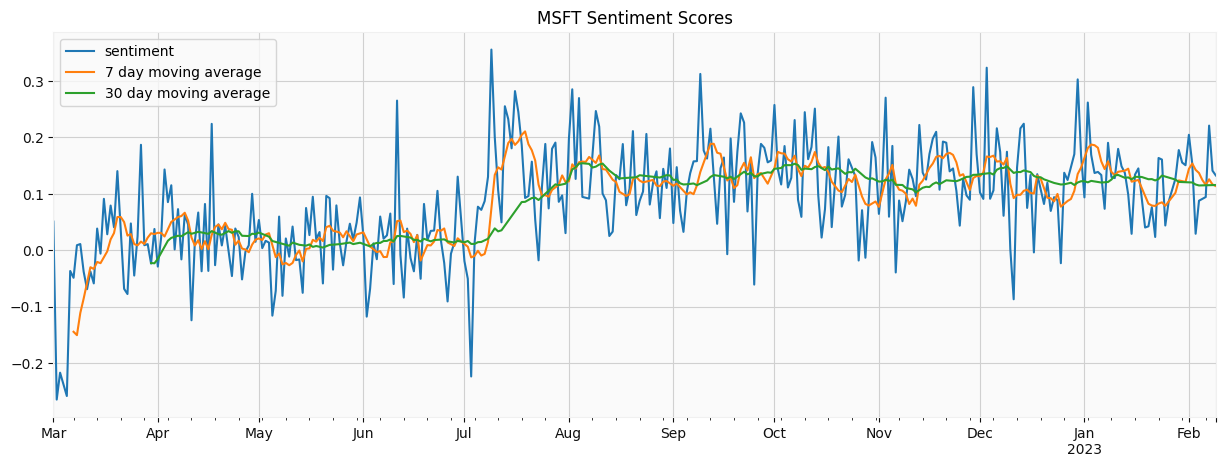

In [385]:
# read the csv file and convert the time column to datetime. ignore the index column
df = pd.read_csv('datasets/msft_sentiments.csv')
df['time'] = pd.to_datetime(df['time'])
# group the dataframe by day, average sentiment scores weighted by relevance
df = pd.DataFrame(df.groupby(pd.Grouper(key='time', freq='D')).apply(lambda x: np.average(x['sentiment'], weights=x['relevance'])), columns=['sentiment']).sort_index(ascending=False)
# # plot the sentiment scores
df.plot(figsize=(15, 5), title='MSFT Sentiment Scores', label='sentiment')
# add the weekly sentiment scores
mv_avg = 7
df['weekly_sentiment'] = df['sentiment'].sort_index().rolling(mv_avg).mean().sort_index(ascending=False)
df['weekly_sentiment'].plot(figsize=(15, 5), title='MSFT Sentiment Scores', label=f'{mv_avg} day moving average')
# add the monthly sentiment scores
mv_avg = 30
df['monthly_sentiment'] = df['sentiment'].sort_index().rolling(mv_avg).mean().sort_index(ascending=False)
df['monthly_sentiment'].plot(figsize=(15, 5), title='MSFT Sentiment Scores', label=f'{mv_avg} day moving average')
plt.xlabel('')
plt.legend()

### Load the daily price data and append it to the news dataset

In [386]:
daily_prices_df = pd.read_csv('datasets/msft_daily_prices.csv', index_col=0)
# sort the prices by date
daily_prices_df.index = pd.to_datetime(daily_prices_df.index)
daily_prices_df.sort_index(ascending=False, inplace=True)
df = df.join(daily_prices_df, how='left').drop(columns=['split_coefficient', 'dividend_amount'], errors='ignore')
# for every nan value, replace it with the value of the previous day
df.fillna(method='ffill', inplace=True)
df

,sentiment,weekly_sentiment,monthly_sentiment,open,high,low,close,adjusted_close,volume,30_day_MA,50_day_MA,100_day_MA,200_day_MA,4_week_high,4_week_low,10_week_high,10_week_low,52_week_high,52_week_low
time,,,,,,,,,,,,,,,,,,,
2023-02-09,0.132467,0.113678,0.115580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-08,0.140957,0.116626,0.115425,273.20,276.760,266.210,266.73,266.730000,54686049.0,242.156667,242.156667,240.378834,253.116658,267.560000,222.310000,267.560000,213.648993,339.88619,213.648993
2023-02-07,0.220816,0.125707,0.115060,260.53,268.775,260.080,267.56,267.560000,50841365.0,241.223333,241.223333,240.158451,253.143094,267.560000,222.310000,267.560000,213.648993,339.88619,213.648993
2023-02-06,0.094310,0.115685,0.114043,257.44,258.300,254.780,256.77,256.770000,22517997.0,240.244333,240.244333,239.997976,253.199031,264.600000,222.310000,264.600000,213.648993,339.88619,213.648993
2023-02-05,0.090266,0.124401,0.113347,257.44,258.300,254.780,256.77,256.770000,22517997.0,240.244333,240.244333,239.997976,253.199031,264.600000,222.310000,264.600000,213.648993,339.88619,213.648993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-05,-0.258166,-0.144424,-0.022638,288.53,289.690,278.530,278.91,276.861355,43157178.0,295.338706,295.338706,314.241815,296.127853,310.514777,276.861355,339.321545,276.861355,339.88619,198.237936
2022-03-04,-0.236631,-0.144424,-0.022638,294.29,295.660,287.165,289.86,287.730925,32369655.0,295.884946,295.884946,314.369188,295.959797,310.514777,278.211365,339.321545,278.211365,339.88619,198.237936
2022-03-03,-0.216885,-0.144424,-0.022638,302.89,303.130,294.050,295.92,293.746413,27314469.0,296.252789,296.252789,314.401214,295.720812,310.514777,278.211365,339.321545,278.211365,339.88619,196.533127


### Load the earnings data and append it to the dataset

In [387]:
# load the earnings dataset
earnings_df = pd.read_csv('datasets/msft_earnings.csv').drop(columns=['fiscalDateEnding'], errors='ignore').set_index('reportedDate')
earnings_df.index = pd.to_datetime(earnings_df.index)
earnings_df.sort_index(ascending=False, inplace=True)
# add a column containing the sum of the past 4 quarters of earnings
earnings_df['past_4_quarters'] = earnings_df['reportedEPS'].sort_index().rolling(4).sum().sort_index(ascending=False)
# take only the last 2 years of earnings
earnings_df = earnings_df[earnings_df.index > datetime.now() - timedelta(days=365*2)]
earnings_df

,reportedEPS,estimatedEPS,surprise,surprisePercentage,past_4_quarters
reportedDate,,,,,
2023-01-24,2.32,2.30,0.02,0.8696,9.12
2022-10-25,2.35,2.30,0.05,2.1739,9.28
2022-07-26,2.23,2.29,-0.06,-2.6201,9.20
2022-04-26,2.22,2.19,0.03,1.3699,9.14
2022-01-25,2.48,2.31,0.17,7.3593,8.95
2021-10-26,2.27,2.08,0.19,9.1346,NaN
2021-07-27,2.17,1.92,0.25,13.0208,NaN
2021-04-27,2.03,1.78,0.25,14.0449,NaN


Append quarter data to the total dataset

### <span style="color:red">TODO Finish appending the earnings dataset</span>

In [388]:
new_df = df
# for every nan value, replace it with the value of the previous day
new_df.fillna(method='ffill', inplace=True)
new_df.head()

,sentiment,weekly_sentiment,monthly_sentiment,open,high,low,close,adjusted_close,volume,30_day_MA,50_day_MA,100_day_MA,200_day_MA,4_week_high,4_week_low,10_week_high,10_week_low,52_week_high,52_week_low
time,,,,,,,,,,,,,,,,,,,
2023-02-09,0.132467,0.113678,0.115580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-08,0.140957,0.116626,0.115425,273.20,276.760,266.21,266.73,266.73,54686049.0,242.156667,242.156667,240.378834,253.116658,267.56,222.31,267.56,213.648993,339.88619,213.648993
2023-02-07,0.220816,0.125707,0.115060,260.53,268.775,260.08,267.56,267.56,50841365.0,241.223333,241.223333,240.158451,253.143094,267.56,222.31,267.56,213.648993,339.88619,213.648993
2023-02-06,0.094310,0.115685,0.114043,257.44,258.300,254.78,256.77,256.77,22517997.0,240.244333,240.244333,239.997976,253.199031,264.60,222.31,264.60,213.648993,339.88619,213.648993
2023-02-05,0.090266,0.124401,0.113347,257.44,258.300,254.78,256.77,256.77,22517997.0,240.244333,240.244333,239.997976,253.199031,264.60,222.31,264.60,213.648993,339.88619,213.648993


### Save the daily, weekly, and monthly datasets

In [352]:
df.to_csv('datasets/msft_daily_dataset.csv')
# subsample dataframe to get weekly data
weekly_df = df.resample('W').agg({'open': 'first', 'high': 'first', 'low': 'first', 'close': 'last', 'adjusted_close': 'last', 'volume': 'first', '30_day_MA': 'first', '50_day_MA': 'first', '100_day_MA': 'first', '200_day_MA': 'first', '4_week_high': 'first', '4_week_low': 'first', '10_week_high': 'first', '10_week_low': 'first', '52_week_high': 'first', '52_week_low': 'first', 'sentiment': 'first', 'weekly_sentiment': 'first', 'monthly_sentiment': 'first'})
# take only indices that have already happened
weekly_df = weekly_df[weekly_df.index < datetime.now()].sort_index(ascending=False)
weekly_df.to_csv('datasets/msft_weekly_dataset.csv')
# subsample dataframe to get weekly data
monthly_df = df.resample('M').agg({'open': 'first', 'high': 'first', 'low': 'first', 'close': 'last', 'adjusted_close': 'last', 'volume': 'first', '30_day_MA': 'first', '50_day_MA': 'first', '100_day_MA': 'first', '200_day_MA': 'first', '4_week_high': 'first', '4_week_low': 'first', '10_week_high': 'first', '10_week_low': 'first', '52_week_high': 'first', '52_week_low': 'first', 'sentiment': 'first', 'weekly_sentiment': 'first', 'monthly_sentiment': 'first'})
# take only indices that have already happened
monthly_df = monthly_df[monthly_df.index < datetime.now()].sort_index(ascending=False)
monthly_df.to_csv('datasets/msft_monthly_dataset.csv')
monthly_df.head()

,open,high,low,close,adjusted_close,volume,30_day_MA,50_day_MA,100_day_MA,200_day_MA,4_week_high,4_week_low,10_week_high,10_week_low,52_week_high,52_week_low,sentiment,weekly_sentiment,monthly_sentiment
time,,,,,,,,,,,,,,,,,,,
2023-01-31,243.08,245.75,237.4000,247.81,247.810000,25740036.0,245.289000,245.289000,247.099952,259.650134,257.220000,234.530000,257.220000,213.648993,339.88619,213.648993,0.093654,0.163123,0.122337
2022-12-31,253.87,256.12,250.9156,239.58,239.580000,26041524.0,237.575407,237.575407,251.938059,264.109344,255.140000,213.648993,278.067780,213.648993,339.88619,213.648993,0.102304,0.131148,0.135021
2022-11-30,234.60,235.74,227.3250,255.14,255.140000,30592271.0,236.307587,236.307587,255.632992,270.513650,249.956857,224.777688,292.025267,224.777688,339.88619,224.777688,0.064437,0.076844,0.121679
2022-10-31,235.41,241.61,234.6600,232.13,231.478837,28880357.0,252.929828,252.929828,261.338716,279.614207,278.067780,232.246677,292.025267,232.246677,339.88619,232.246677,0.257380,0.145089,0.144274
2022-09-30,258.87,260.89,255.4100,232.90,232.246677,23263431.0,275.880864,275.880864,268.084187,288.602315,292.025267,250.659914,292.025267,241.067371,339.88619,228.285874,0.048206,0.114290,0.124572


### Plot everything while scaling the sentiments by a factor of 10

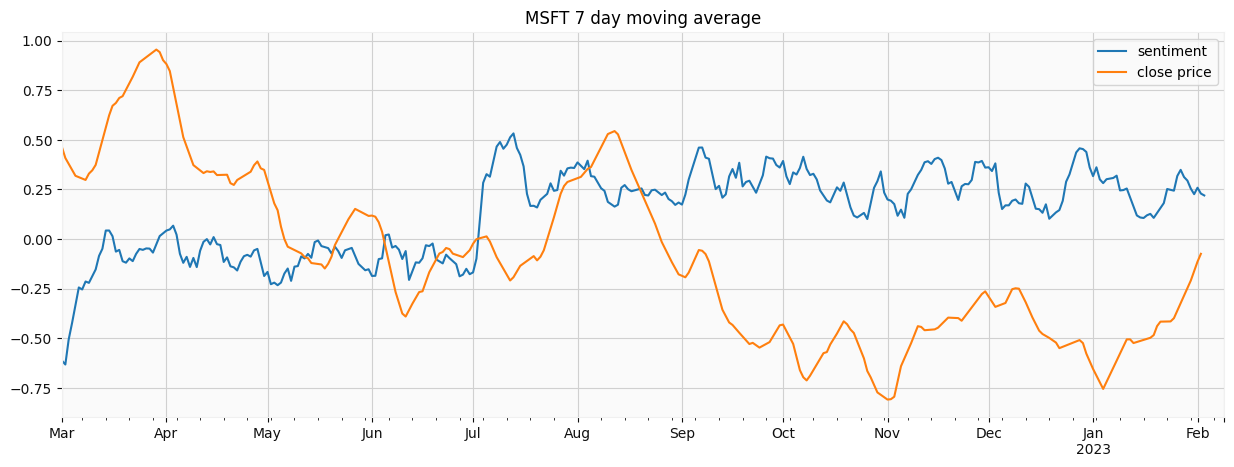

In [353]:
# plot the sentiment scores
mv_avg = 7
temp_df = df.apply(lambda x: (x - x.min()) / (x.max() - x.min()) * 2 - 1)
# multiply the sentiment scores by 2 to make the trendline more visible
temp_df['sentiment'].rolling(mv_avg).mean().plot(figsize=(15, 5), title=f'MSFT {mv_avg} day moving average', label=f'sentiment')
# new_df['close'].plot(figsize=(15, 5), title='MSFT Sentiment Scores', label='close')
temp_df['close'].rolling(mv_avg).mean().plot(figsize=(15, 5), title=f'MSFT {mv_avg} day moving average', label=f'close price')
# add vertical lines to indicate 
# plt.axvline(x='2022-07-13', color='red', linestyle='--')
# plt.axvline(x='2022-08-12', color='black', linestyle='--')
plt.xlabel('')
plt.legend()

# Step 2: Run in XGBoost and define the most impacting features

### <span style="color:red">TODO make it predict the weekly price instead. And feed it volume, high, and low of the previous days (move every item to be a day backward when feeding)</span>

In [354]:
from sklearn.metrics import mean_squared_error
import xgboost as xgb
# import minmaxscaler
# from sklearn.preprocessing import MinMaxScaler

## Split to train and test data

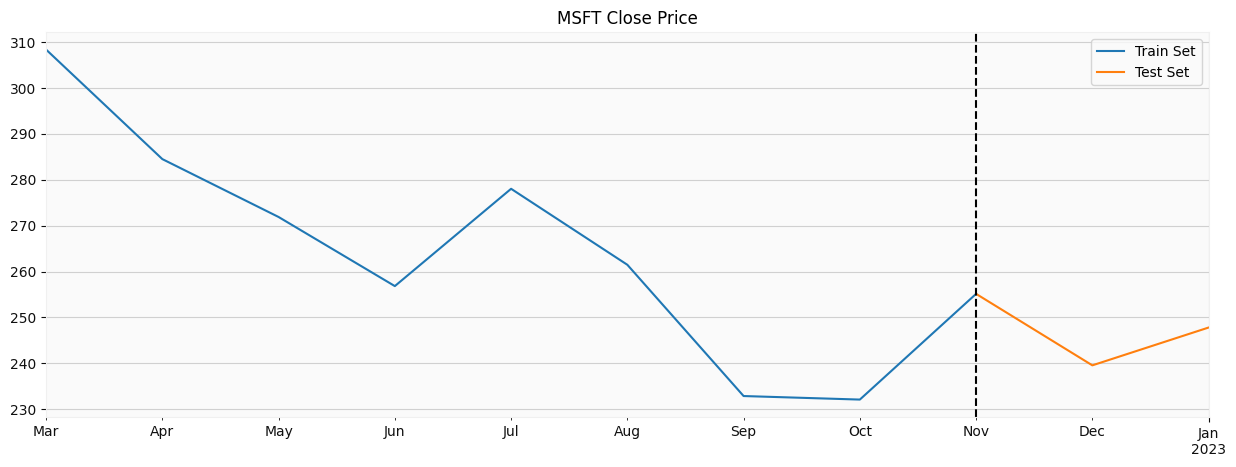

In [367]:
# df = pd.read_csv('datasets/msft_daily_dataset.csv', index_col=0).drop(columns=['adjusted_close']).dropna()
# # raise the all the columns up by one day so that the model only gets the daily open price and the rest of the data from yesterday
# for col in set(df.columns) - {'close', 'open'}: df[col] = df[col][1:].shift(-1)
# # shift the close column by 1
# df['close'] = df['close'][:-1]
# df = df.dropna(axis=0)

# df = pd.read_csv('datasets/msft_weekly_dataset.csv', index_col=0).drop(columns=['adjusted_close']).dropna()
df = pd.read_csv('datasets/msft_monthly_dataset.csv', index_col=0).drop(columns=['adjusted_close']).dropna()

df.index = pd.to_datetime(df.index)
df.sort_index(ascending=False, inplace=True)
# convert all columns to numeric except for the index
df = df.apply(pd.to_numeric, errors='ignore')
# drop any column that contains a date time value
# df = df.drop(columns=[col for col in df.columns if df[col].dtype != 'float64']).dropna()
df = df.dropna(axis=0)
# get all times before the last month
train_df, test_df = df[df.index <= df.index.max() - pd.DateOffset(months=2)], df[df.index >= df.index.max() - pd.DateOffset(months=2)]
# plot both the training and testing data
train_df['close'].plot(figsize=(15, 5), title='MSFT Close Price', label='Train Set')
test_df['close'].plot(figsize=(15, 5), title='MSFT Close Price', label='Test Set')
# add vertical lines to indicate the separation between the training and testing data
plt.axvline(x=train_df.index[0], color='black', linestyle='--')
plt.xlabel('')
plt.legend()
# df

## create a xgboost regression
The model will be trained twice for comparison - with and without sentiment to see its impact

In [368]:
# %%timeit
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=200, eval_metric='rmse', learning_rate=0.1, max_depth=10, subsample=0.8, colsample_bytree=0.8, random_state=42)
reg_no_sent = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=200, eval_metric='rmse', learning_rate=0.1, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42)

# split into train and test sets
X_train, y_train = train_df.drop(columns=['close']), train_df['close']
X_test, y_test = test_df.drop(columns=['close']), test_df['close']

x_no_sent_train = X_train.drop(columns=['sentiment'])
x_no_sent_test = X_test.drop(columns=['sentiment'])

reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)
reg_no_sent.fit(x_no_sent_train, y_train, eval_set=[(x_no_sent_train, y_train), (x_no_sent_test, y_test)], verbose=True)
# print('done')


[0]	validation_0-rmse:242.03161	validation_1-rmse:223.96745
[1]	validation_0-rmse:220.82737	validation_1-rmse:202.66705
[2]	validation_0-rmse:201.17883	validation_1-rmse:182.91137
[3]	validation_0-rmse:183.86617	validation_1-rmse:165.48529
[4]	validation_0-rmse:167.93821	validation_1-rmse:149.43236
[5]	validation_0-rmse:153.04487	validation_1-rmse:134.39863
[6]	validation_0-rmse:139.90978	validation_1-rmse:121.11486
[7]	validation_0-rmse:127.67421	validation_1-rmse:108.71321
[8]	validation_0-rmse:116.67692	validation_1-rmse:97.53681
[9]	validation_0-rmse:106.95184	validation_1-rmse:87.62249
[10]	validation_0-rmse:98.37710	validation_1-rmse:78.84965
[11]	validation_0-rmse:90.31118	validation_1-rmse:70.56276
[12]	validation_0-rmse:82.70063	validation_1-rmse:62.70381
[13]	validation_0-rmse:75.85881	validation_1-rmse:55.59568
[14]	validation_0-rmse:69.91377	validation_1-rmse:52.93174
[15]	validation_0-rmse:63.99384	validation_1-rmse:46.73424
[16]	validation_0-rmse:58.83321	validation_1-rms

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=200,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

<AxesSubplot: title={'center': 'Feature Importance'}>

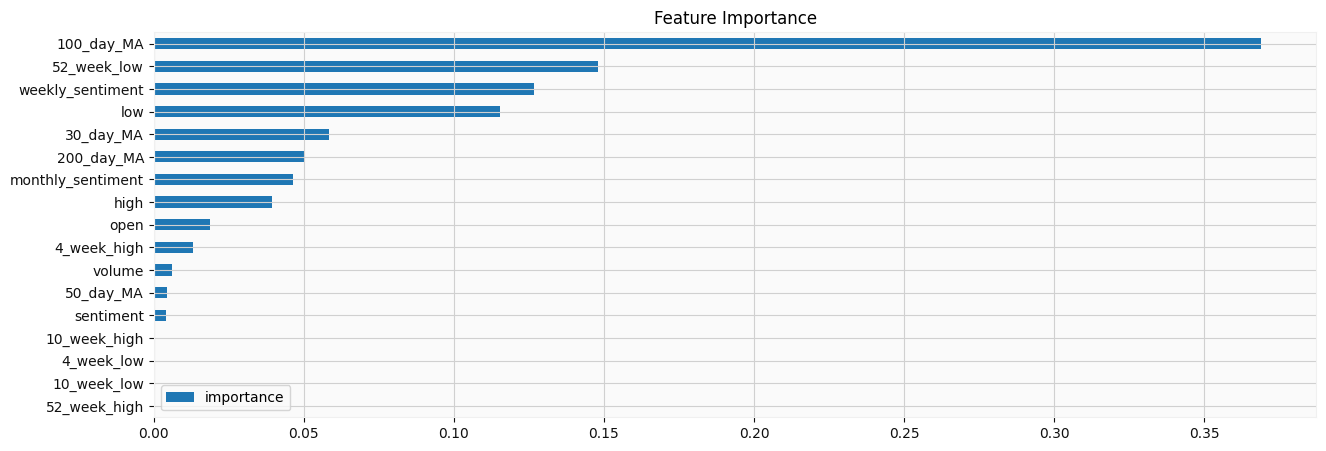

In [369]:
fi = pd.DataFrame(reg.feature_importances_, index=reg.feature_names_in_, columns=['importance']).sort_values(by='importance')
fi.plot(kind='barh', figsize=(15, 5), title='Feature Importance')

## Forecast on Test

In [370]:
X_test['prediction'] = reg.predict(X_test)
x_no_sent_test['prediction'] = reg_no_sent.predict(x_no_sent_test)
df = df.copy().merge(X_test[['prediction']], how='left', left_index=True, right_index=True)
# df_no_sent = df.copy().merge(x_no_sent_test[['prediction']], how='left', left_index=True, right_index=True)

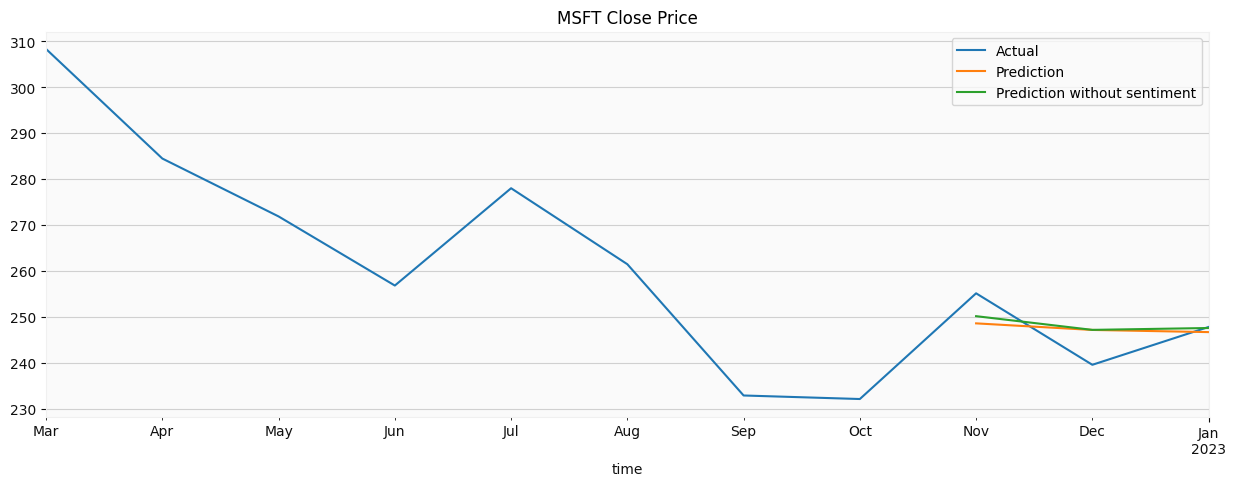

In [371]:
df['close'].plot(figsize=(15, 5), title='MSFT Close Price', label='Actual')
df['prediction'].plot(figsize=(15, 5), title='MSFT Close Price', label='Prediction')
x_no_sent_test['prediction'].plot(figsize=(15, 5), title='MSFT Close Price', label='Prediction without sentiment')
# plot the prediction once every 7 days
# df['prediction'].iloc[::7].plot(figsize=(15, 5), title='MSFT Close Price', label='smoothed Prediction')
plt.legend()

Print out the root mean squared error

In [372]:
score = np.sqrt(mean_squared_error(y_test, X_test['prediction']))
score_no_sent = np.sqrt(mean_squared_error(y_test, x_no_sent_test['prediction']))
print(f'RMSE: {score:.4f}, RMSE without sentiment: {score_no_sent:.4f}')

RMSE: 5.8191, RMSE without sentiment: 5.2468


The worst predictions with sentiment:

In [373]:
X_test['error'] = np.abs(X_test['prediction'] - y_test)
X_test['date'] = X_test.index
print(X_test.groupby(['date']).mean().sort_values(ascending=False, by='error')['error'].head())

date
2022-12-31    7.585955
2022-11-30    6.541703
2023-01-31    1.115847
Name: error, dtype: float64


The worst predictions without sentiments

In [374]:
x_no_sent_test['error'] = np.abs(x_no_sent_test['prediction'] - y_test)
x_no_sent_test['date'] = x_no_sent_test.index
print(x_no_sent_test.groupby(['date']).mean().sort_values(ascending=False, by='error')['error'].head())

date
2022-12-31    7.600832
2022-11-30    4.976349
2023-01-31    0.223330
Name: error, dtype: float64


### RMSE Results:
- Monthly:
    * SENTIMENT: 5.1714
    * WITHOUT SENTIMENT: 4.9061
    * note that for monthly, the averaged news sentiment plays a much larger role in prediction
- Weekly: 
    * SENTIMENT: 7.8609
    * WITHOUT SENTIMENT: 8.0768
- Daily: 
    * SENTIMENT: 4.3946 
    * WITHOUT SENTIMENT: 4.1924

# Next steps
- find out how to milk your other features better - instead of just dropping volume, make it delayed by one day/week - same for min and high
- Create more robust cross validation
- Move to predicting weekly data. maintain the mean across the weekly sentiment as well - the model is currently making daily predictions still
- switch to a model of only predicting sentiment towards stock: bullish, somwhat bullish, bearish, somwhat bearish, neutral, somwhat neutral